In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Loading Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from itertools import cycle                   
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Data

In [3]:
train_data = pd.read_csv('../Dataset/train.csv', engine='python', encoding='utf-8')
valid_data = pd.read_csv('../Dataset/valid.csv', engine='python', encoding='utf-8')

data = pd.concat([train_data, valid_data])
data = data.drop(columns = ['Id', 'CreationDate'])
data.head()

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ


# 3. Initial Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   60000 non-null  object
 1   Body    60000 non-null  object
 2   Tags    60000 non-null  object
 3   Y       60000 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


[Text(0, 0, '20000'), Text(0, 0, '20000'), Text(0, 0, '20000')]

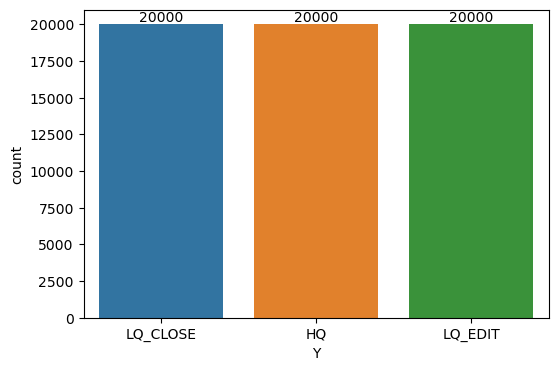

In [5]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

# 4. Preprocessing Text

### 4.1. Labeling 

In [6]:
data['label'] = data['Y'].map({'HQ' : 0, 'LQ_EDIT' : 1, 'LQ_CLOSE' : 2})
data.head()

,Title,Body,Tags,Y,label
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE,2
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ,0
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ,0
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ,0


### 4.2. Cleaning Tags Column

In [7]:
def clean_text_tags(text):
    text = re.sub("<|>", " ", text)
    return text

data['Tags'] = data['Tags'].progress_apply(clean_text_tags)
data.head()

  0%|          | 0/60000 [00:00<?, ?it/s]

,Title,Body,Tags,Y,label
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0


### 4.3. Merging Columns

In [8]:
# data['combined_text'] = data['Title'] + ' ' + data['Body'] + ' ' + data['Tags']
# data['combined_text'] = data['Title'] + ' ' + data['Body']
data['combined_text'] = data['Body']
data.head()

,Title,Body,Tags,Y,label,combined_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2,<p>I'm already familiar with repeating tasks e...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0,<p>I'd like to understand why Java 8 Optionals...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0,<p>I am attempting to overlay a title over an ...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0,"<p>The question is very simple, but I just cou..."
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0,<p>I'm using custom floatingactionmenu. I need...


### 4.4. Cleaning combined_text Column

In [10]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def lower_text(text):
    return text.lower()

def clean_text(text):
    text = re.sub(CLEANR, ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'www\S+', ' ', text)
    # text = re.sub("#+"," ", text)
    # text = re.sub("@[\w]*"," ", text)
    text = re.sub("[^a-z0-9\s]"," ", text)
    # text = re.sub("@[A-Za-z0-9_]+"," ", text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\b', '', text)
    text = re.sub(r'\r', '', text)
    text = re.sub('\s+', ' ', text)
    # text = re.sub(r'\\[a-zA-Z0-9]{1}', '', text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def lemmatizer(text):
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))
    return ''.join(sentence)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [11]:
data['clean_text'] = data['combined_text'] \
                    .progress_apply(lower_text) \
                    .progress_apply(lambda x: BeautifulSoup(x, 'html.parser', ).text)
                    # .progress_apply(lemmatizer) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)])) \
                    # .progress_apply(clean_text)
                    # .progress_apply(lambda x: BeautifulSoup(x, features="lxml" ).text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

C:\Users\indiz\AppData\Local\Temp\ipykernel_13308\2707696130.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  .progress_apply(lambda x: BeautifulSoup(x, 'html.parser', ).text)
c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


,Title,Body,Tags,Y,label,combined_text,clean_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2,<p>I'm already familiar with repeating tasks e...,i'm already familiar with repeating tasks ever...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0,<p>I'd like to understand why Java 8 Optionals...,i'd like to understand why java 8 optionals we...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0,<p>I am attempting to overlay a title over an ...,i am attempting to overlay a title over an ima...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0,"<p>The question is very simple, but I just cou...","the question is very simple, but i just could ..."
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0,<p>I'm using custom floatingactionmenu. I need...,i'm using custom floatingactionmenu. i need to...
...,...,...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",html css flexbox,LQ_CLOSE,2,"<p>I have a menu, and I'd like the div.right-c...","i have a menu, and i'd like the div.right-cont..."
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,c++,LQ_CLOSE,2,<p>I try to multiply an integer by a double bu...,i try to multiply an integer by a double but i...
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,django django-views django-templates,LQ_EDIT,1,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,*urls.py*\r\n //urls.py file\r\n fro...
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,javascript php html,LQ_CLOSE,2,<p>I have a controller inside which a server i...,i have a controller inside which a server is c...


In [12]:
data['clean_text'].values

array(['i\'m already familiar with repeating tasks every n seconds by using java.util.timer and java.util.timertask. but lets say i want to print "hello world" to the console every random seconds from 1-5. unfortunately i\'m in a bit of a rush and don\'t have any code to show so far. any help would be apriciated.  \n',
       "i'd like to understand why java 8 optionals were designed to be immutable.  is it just for thread-safety?\n",
       "i am attempting to overlay a title over an image - with the image darkened with a lower opacity. however, the opacity effect is changing the overlaying text as well - making it dim. any fix to this? here is what is looks like:\n\nand here is my code for the custom component (article preview - which the above image is a row of article preview components): \n//component for article preview touchable image\n/* will require the following\n- rss feed and api\n- user's keyword interests from parse in home.js\n- parse db needs to be augmented to include 

In [179]:
# np.savetxt(r'clean_text.csv', data['clean_text'].values, fmt='%s')

### 4.5. Reduce the sentence to be processed according to the desired number of words

<Axes: xlabel='text_len'>

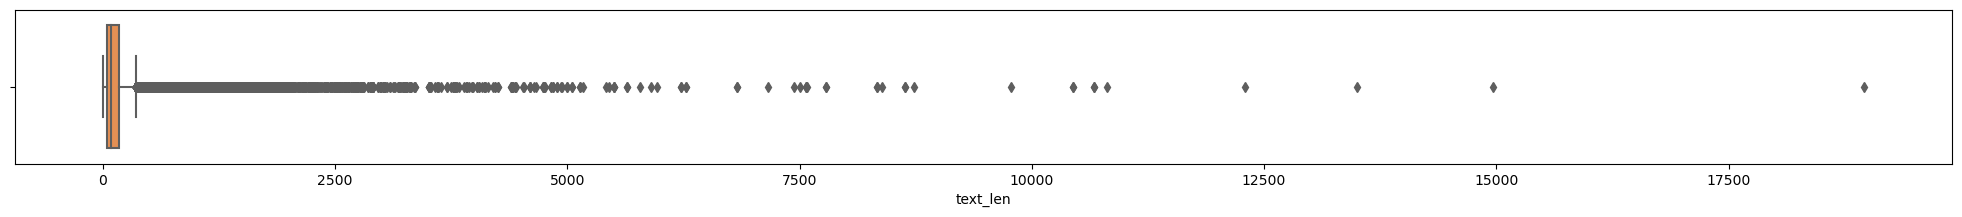

In [13]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

In [17]:
print(data['text_len'].quantile(0.25))
print(data['text_len'].quantile(0.8))

47.0
207.0


47.0
207.0


<Axes: xlabel='text_len'>

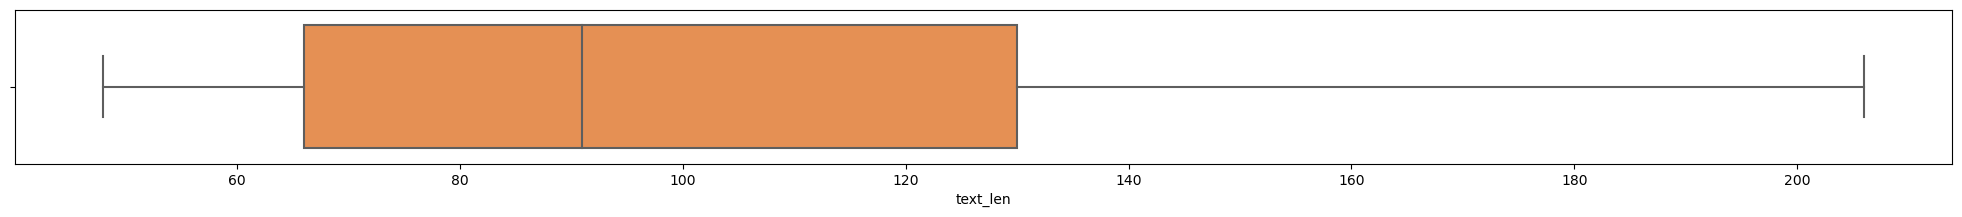

In [18]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(0.8)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

### 4.6. Visualize # of label after preprocessing

[Text(0, 0, '10382'), Text(0, 0, '11892'), Text(0, 0, '10307')]

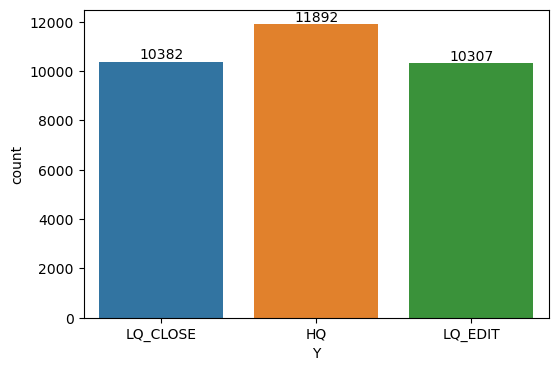

In [19]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting data into Training, Testing, and Validating data

In [20]:
X = data['clean_text']
Y = to_categorical(data['label'])

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(22871,)
(6451,)
(3259,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [22]:
vocab_size = 10000
embedding_dim = 128
max_length = 210
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [23]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

119483


### 5.4. Build Deep Learning Models

In [43]:
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.) ### 0.9
# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.) ### 0.8004
# initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.) ### 0.8842
# initializer = tf.keras.initializers.Zeros() ### 0.3400
# initializer = tf.keras.initializers.Ones()
# initializer = tf.keras.initializers.GlorotNormal() ### 0.8963
# initializer = tf.keras.initializers.GlorotUniform() ### 0.8916
initializer = tf.keras.initializers.HeNormal() ### 0.9082
# initializer = tf.keras.initializers.HeUniform()
# initializer = tf.keras.initializers.Identity()
# initializer = tf.keras.initializers.Orthogonal()
# initializer = tf.keras.initializers.Constant(3.)
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.4))
    model.add(MaxPooling1D())

    # model.add(Conv1D(512, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(MaxPooling1D())
    # model.add(Dropout(0.4))
    # model.add(BatchNormalization())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    # model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(ReLU())
    # model.add(Dropout(0.4))
    model.add(MaxPooling1D())

    model.add(Conv1D(32, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))
    return model
    

model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.01)
opt = Adam(learning_rate = 0.000001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 210, 128)          1280000   
                                                                 
 conv1d_21 (Conv1D)          (None, 210, 64)           24640     
                                                                 
 batch_normalization_21 (Bat  (None, 210, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_21 (ReLU)             (None, 210, 64)           0         
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 105, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 105, 64)          

### 5.5. Training the Model

In [50]:
num_epoch = 100
batch_size = 64

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20)
)

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    # callbacks=[lr_schedule], 
                    validation_data = (testing_padded, testing_label))

Epoch 1/100
358/358 [==============================] - 5s 13ms/step - loss: 0.4913 - accuracy: 0.8779 - val_loss: 0.6979 - val_accuracy: 0.7954
Epoch 2/100
358/358 [==============================] - 4s 12ms/step - loss: 0.4931 - accuracy: 0.8789 - val_loss: 0.7006 - val_accuracy: 0.7955
Epoch 3/100
358/358 [==============================] - 4s 12ms/step - loss: 0.4926 - accuracy: 0.8785 - val_loss: 0.6976 - val_accuracy: 0.7960
Epoch 4/100
358/358 [==============================] - 4s 12ms/step - loss: 0.4895 - accuracy: 0.8801 - val_loss: 0.7009 - val_accuracy: 0.7966
Epoch 5/100
358/358 [==============================] - 4s 12ms/step - loss: 0.4877 - accuracy: 0.8822 - val_loss: 0.6985 - val_accuracy: 0.7958
Epoch 6/100
358/358 [==============================] - 4s 12ms/step - loss: 0.4910 - accuracy: 0.8776 - val_loss: 0.7002 - val_accuracy: 0.7968
Epoch 7/100
358/358 [==============================] - 4s 12ms/step - loss: 0.4856 - accuracy: 0.8834 - val_loss: 0.7011 - val_accuracy:

# 6. Evaluating Performance

### 6.21. Plotting Accuracy and Loss of the Model

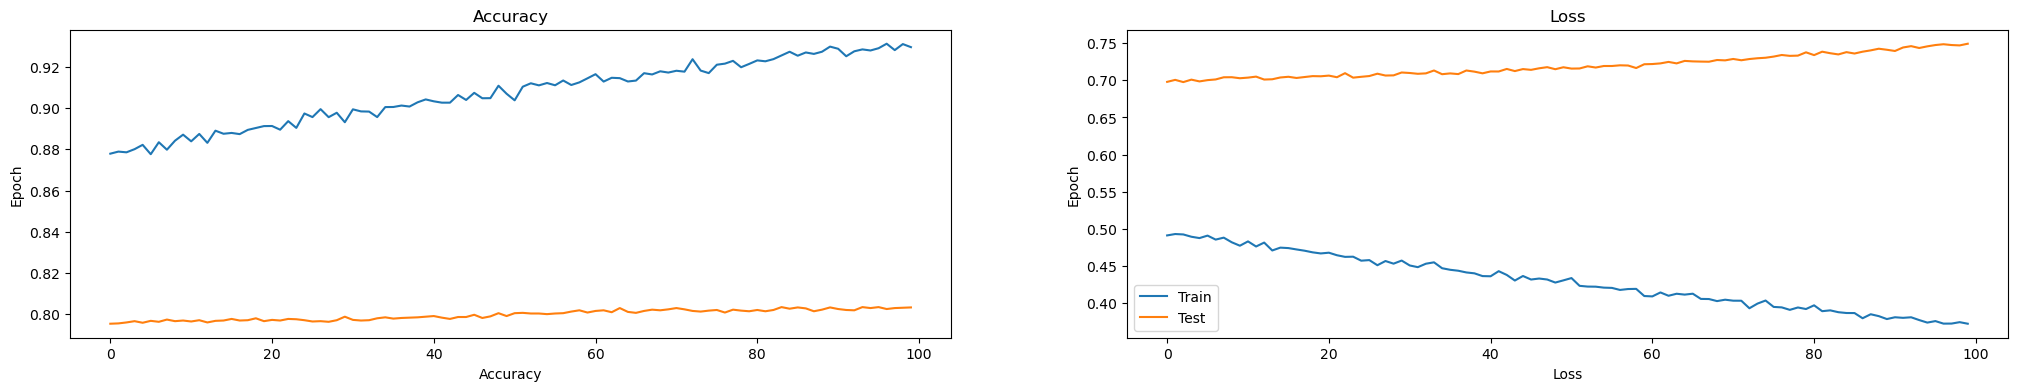

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

### 6.2. Confusion Matrix

93/93 [==============================] - 1s 5ms/step


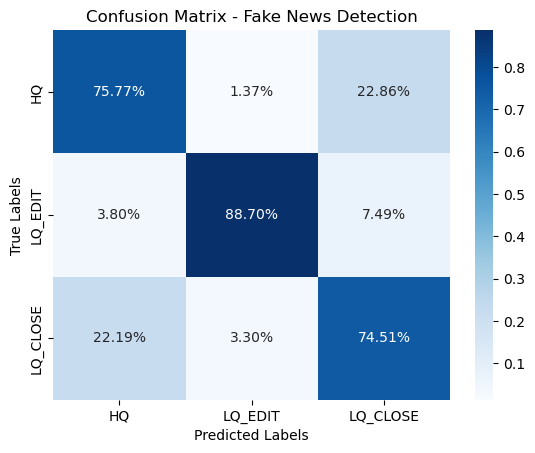

In [39]:
labels = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [40]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(validating_padded))

print(classification_report(validating_label.argmax(axis=1),y_pred.argmax(axis=1)))

93/93 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1098
           1       0.94      0.89      0.91       894
           2       0.69      0.75      0.72       969

    accuracy                           0.79      2961
   macro avg       0.80      0.80      0.80      2961
weighted avg       0.80      0.79      0.79      2961



### 6.3. ROC Curve 

93/93 [==============================] - 0s 2ms/step


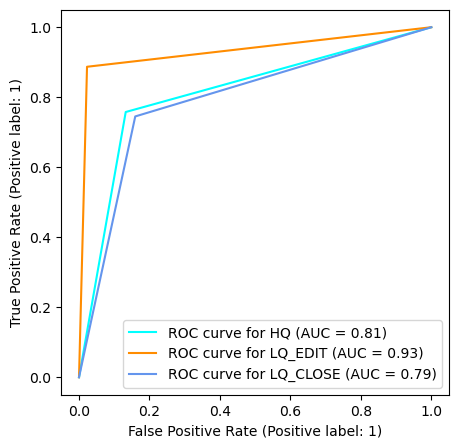

In [41]:
y_pred = np.rint(model.predict(validating_padded))
n_classes = 3

fig, ax = plt.subplots(figsize=(5, 5))
target_names = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        validating_label[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )